# Final Project Team 7 AAI-530

## Team Members 
- Fernando Calderon
- Paul Parks
- Will Kencel


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from math import sqrt
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime

## Import Dataset

In [2]:
file_path = './Dataset/Smart_Home_Dataset_with_weather_Information.csv'
df = pd.read_csv(file_path)

# Remove the last row of the dfframe
df = df.iloc[:-1]

# Convert the 'time' column from UNIX timestamp to datetime
df['time'] = pd.to_datetime(df['time'], unit='s')
df['time'] = pd.DatetimeIndex(pd.date_range('2016-01-01 00:00', periods=len(df),  freq='min'))
df.set_index('time', inplace=True)

df.head()

C:\Users\paula\AppData\Local\Temp\ipykernel_22296\2011437542.py:2: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
C:\Users\paula\AppData\Local\Temp\ipykernel_22296\2011437542.py:8: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s')


use [kW]  gen [kW]  House overall [kW]  Dishwasher [kW]  \
time                                                                           
2016-01-01 00:00:00  0.932833  0.003483            0.932833         0.000033   
2016-01-01 00:01:00  0.934333  0.003467            0.934333         0.000000   
2016-01-01 00:02:00  0.931817  0.003467            0.931817         0.000017   
2016-01-01 00:03:00  1.022050  0.003483            1.022050         0.000017   
2016-01-01 00:04:00  1.139400  0.003467            1.139400         0.000133   

                     Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]  \
time                                                                    
2016-01-01 00:00:00        0.020700        0.061917          0.442633   
2016-01-01 00:01:00        0.020717        0.063817          0.444067   
2016-01-01 00:02:00        0.020700        0.062317          0.446067   
2016-01-01 00:03:00        0.106900        0.068517          0.446583   
2016-01-01 00:04:00        0.236933        0.063983          0.446533   

                     Fridge [kW]  Wine cellar [kW]  Garage door [kW]  ...  \
time                                                                  ...   
2016-01-01 00:00:00     0.124150          0.006983          0.013083  ...   
2016-01-01 00:01:00     0.124000          0.006983          0.013117  ...   
2016-01-01 00:02:00     0.123533          0.006983          0.013083  ...   
2016-01-01 00:03:00     0.123133          0.006983          0.013000  ...   
2016-01-01 00:04:00     0.122850          0.006850          0.012783  ...   

                     visibility  summary  apparentTemperature  pressure  \
time                                                                      
2016-01-01 00:00:00        10.0    Clear                29.26   1016.91   
2016-01-01 00:01:00        10.0    Clear                29.26   1016.91   
2016-01-01 00:02:00        10.0    Clear                29.26   1016.91   
2016-01-01 00:03:00        10.0    Clear                29.26   1016.91   
2016-01-01 00:04:00        10.0    Clear                29.26   1016.91   

                     windSpeed  cloudCover  windBearing  precipIntensity  \
time                                                                       
2016-01-01 00:00:00       9.18  cloudCover        282.0              0.0   
2016-01-01 00:01:00       9.18  cloudCover        282.0              0.0   
2016-01-01 00:02:00       9.18  cloudCover        282.0              0.0   
2016-01-01 00:03:00       9.18  cloudCover        282.0              0.0   
2016-01-01 00:04:00       9.18  cloudCover        282.0              0.0   

                     dewPoint precipProbability  
time                                             
2016-01-01 00:00:00      24.4               0.0  
2016-01-01 00:01:00      24.4               0.0  
2016-01-01 00:02:00      24.4               0.0  
2016-01-01 00:03:00      24.4               0.0  
2016-01-01 00:04:00      24.4               0.0  

[5 rows x 31 columns]

# Cleaning

In [3]:
# replace the string cloudCover with the mean value
df['cloudCover'] = df['cloudCover'].replace('cloudCover', None)
# Convert the cloudCover column to a float
df['cloudCover'] = df['cloudCover'].astype(float)
# replace nan values with the mean of the column
df['cloudCover'] = df['cloudCover'].fillna(df['cloudCover'].mean())
# View the different strings in cloudCover
df['cloudCover'].unique()

array([0.22588514, 0.75      , 0.        , 1.        , 0.31      ,
       0.44      , 0.13      , 0.19      , 0.25      , 0.16      ,
       0.21      , 0.15      , 0.14      , 0.27      , 0.28      ,
       0.17      , 0.05      , 0.1       , 0.26      , 0.29      ,
       0.11      , 0.09      , 0.12      , 0.06      , 0.02      ,
       0.08      , 0.04      , 0.35      , 0.22      , 0.23      ,
       0.54      , 0.39      , 0.03      , 0.07      , 0.76      ,
       0.62      , 0.18      , 0.79      , 0.48      , 0.24      ,
       0.57      , 0.41      , 0.78      , 0.2       , 0.77      ,
       0.46      , 0.55      , 0.01      , 0.51      , 0.47      ,
       0.5       , 0.4       , 0.3       , 0.43      , 0.33      ,
       0.6       , 0.68      , 0.66      , 0.45      , 0.34      ,
       0.52      , 0.67      , 0.49      , 0.37      , 0.36      ,
       0.61      , 0.38      , 0.42      , 0.53      , 0.63      ,
       0.32      , 0.56      , 0.58      , 0.72      , 0.73   

In [4]:
# show the values of summary
print(df['summary'].unique())
df['summary_encoded'] = pd.factorize(df['summary'])[0]
print(df['summary_encoded'].unique())

# drop the summary column
df = df.drop(columns='summary')

['Clear' 'Mostly Cloudy' 'Overcast' 'Partly Cloudy' 'Drizzle' 'Light Rain'
 'Rain' 'Light Snow' 'Flurries' 'Breezy' 'Snow' 'Rain and Breezy' 'Foggy'
 'Breezy and Mostly Cloudy' 'Breezy and Partly Cloudy'
 'Flurries and Breezy' 'Dry' 'Heavy Snow']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [5]:
print(df['icon'].unique())
df['icon_encoded'] = pd.factorize(df['icon'])[0]
print(df['icon_encoded'].unique())

# drop the icon column
df = df.drop(columns='icon')

['clear-night' 'partly-cloudy-night' 'clear-day' 'cloudy'
 'partly-cloudy-day' 'rain' 'snow' 'wind' 'fog']
[0 1 2 3 4 5 6 7 8]


In [6]:
df.describe()

use [kW]       gen [kW]  House overall [kW]  Dishwasher [kW]  \
count  503910.000000  503910.000000       503910.000000    503910.000000   
mean        0.858962       0.076229            0.858962         0.031368   
std         1.058207       0.128428            1.058207         0.190951   
min         0.000000       0.000000            0.000000         0.000000   
25%         0.367667       0.003367            0.367667         0.000000   
50%         0.562333       0.004283            0.562333         0.000017   
75%         0.970250       0.083917            0.970250         0.000233   
max        14.714567       0.613883           14.714567         1.401767   

       Furnace 1 [kW]  Furnace 2 [kW]  Home office [kW]    Fridge [kW]  \
count   503910.000000   503910.000000     503910.000000  503910.000000   
mean         0.099210        0.136779          0.081287       0.063556   
std          0.169059        0.178631          0.104466       0.076199   
min          0.000017        0.000067          0.000083       0.000067   
25%          0.020233        0.064400          0.040383       0.005083   
50%          0.020617        0.066633          0.042217       0.005433   
75%          0.068733        0.080633          0.068283       0.125417   
max          1.934083        0.794933          0.971750       0.851267   

       Wine cellar [kW]  Garage door [kW]  ...  apparentTemperature  \
count     503910.000000     503910.000000  ...        503910.000000   
mean           0.042137          0.014139  ...            48.263382   
std            0.057967          0.014292  ...            22.027916   
min            0.000017          0.000017  ...           -32.080000   
25%            0.007133          0.012733  ...            31.090000   
50%            0.008083          0.012933  ...            50.320000   
75%            0.053192          0.013100  ...            66.260000   
max            1.273933          1.088983  ...           101.120000   

            pressure      windSpeed     cloudCover    windBearing  \
count  503910.000000  503910.000000  503910.000000  503910.000000   
mean     1016.301625       6.649936       0.225885     202.356843   
std         7.895185       3.982716       0.289890     106.520474   
min       986.400000       0.000000       0.000000       0.000000   
25%      1011.290000       3.660000       0.040000     148.000000   
50%      1016.530000       5.930000       0.120000     208.000000   
75%      1021.480000       8.940000       0.290000     295.000000   
max      1042.460000      22.910000       1.000000     359.000000   

       precipIntensity       dewPoint  precipProbability  summary_encoded  \
count    503910.000000  503910.000000      503910.000000    503910.000000   
mean          0.002598      38.694013           0.056453         1.026771   
std           0.011257      19.087939           0.165836         2.054667   
min           0.000000     -27.240000           0.000000         0.000000   
25%           0.000000      24.600000           0.000000         0.000000   
50%           0.000000      39.030000           0.000000         0.000000   
75%           0.000000      54.790000           0.000000         1.000000   
max           0.191000      75.490000           0.840000        17.000000   

        icon_encoded  
count  503910.000000  
mean        1.696803  
std         1.744335  
min         0.000000  
25%         0.000000  
50%         2.000000  
75%         2.000000  
max         8.000000  

[8 rows x 31 columns]

In [7]:
df.isnull().sum()

use [kW]               0
gen [kW]               0
House overall [kW]     0
Dishwasher [kW]        0
Furnace 1 [kW]         0
Furnace 2 [kW]         0
Home office [kW]       0
Fridge [kW]            0
Wine cellar [kW]       0
Garage door [kW]       0
Kitchen 12 [kW]        0
Kitchen 14 [kW]        0
Kitchen 38 [kW]        0
Barn [kW]              0
Well [kW]              0
Microwave [kW]         0
Living room [kW]       0
Solar [kW]             0
temperature            0
humidity               0
visibility             0
apparentTemperature    0
pressure               0
windSpeed              0
cloudCover             0
windBearing            0
precipIntensity        0
dewPoint               0
precipProbability      0
summary_encoded        0
icon_encoded           0
dtype: int64

In [8]:
df.dtypes

use [kW]               float64
gen [kW]               float64
House overall [kW]     float64
Dishwasher [kW]        float64
Furnace 1 [kW]         float64
Furnace 2 [kW]         float64
Home office [kW]       float64
Fridge [kW]            float64
Wine cellar [kW]       float64
Garage door [kW]       float64
Kitchen 12 [kW]        float64
Kitchen 14 [kW]        float64
Kitchen 38 [kW]        float64
Barn [kW]              float64
Well [kW]              float64
Microwave [kW]         float64
Living room [kW]       float64
Solar [kW]             float64
temperature            float64
humidity               float64
visibility             float64
apparentTemperature    float64
pressure               float64
windSpeed              float64
cloudCover             float64
windBearing            float64
precipIntensity        float64
dewPoint               float64
precipProbability      float64
summary_encoded          int64
icon_encoded             int64
dtype: object

In [9]:
# Print the total rows with null values
print(df.isnull().sum().sum())

# Fill the null values with the forward fill method
df.fillna(method='ffill', inplace=True)

0


C:\Users\paula\AppData\Local\Temp\ipykernel_22296\1930171081.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


# EDA

In [10]:
# Power-related columns
power_array = [
    'use [kW]', 
    'gen [kW]', 
    # 'House overall [kW]', 
    'Dishwasher [kW]', 
    'Furnace 1 [kW]', 
    'Furnace 2 [kW]', 
    'Home office [kW]', 
    'Fridge [kW]', 
    'Wine cellar [kW]', 
    'Garage door [kW]', 
    'Kitchen 12 [kW]', 
    'Kitchen 14 [kW]', 
    'Kitchen 38 [kW]', 
    'Barn [kW]', 
    'Well [kW]', 
    'Microwave [kW]', 
    'Living room [kW]', 
    # 'Solar [kW]'
]

# Weather-related columns
weather_array = [
    'temperature', 
    # 'icon', 
    'icon_encoded',
    'humidity', 
    'visibility', 
    # 'summary', 
    'summary_encoded',
    'apparentTemperature', 
    'pressure', 
    'windSpeed', 
    'cloudCover', 
    'windBearing', 
    'precipIntensity', 
    'dewPoint', 
    'precipProbability'
]

# all columns
all_columns = power_array + weather_array


## View the correlations

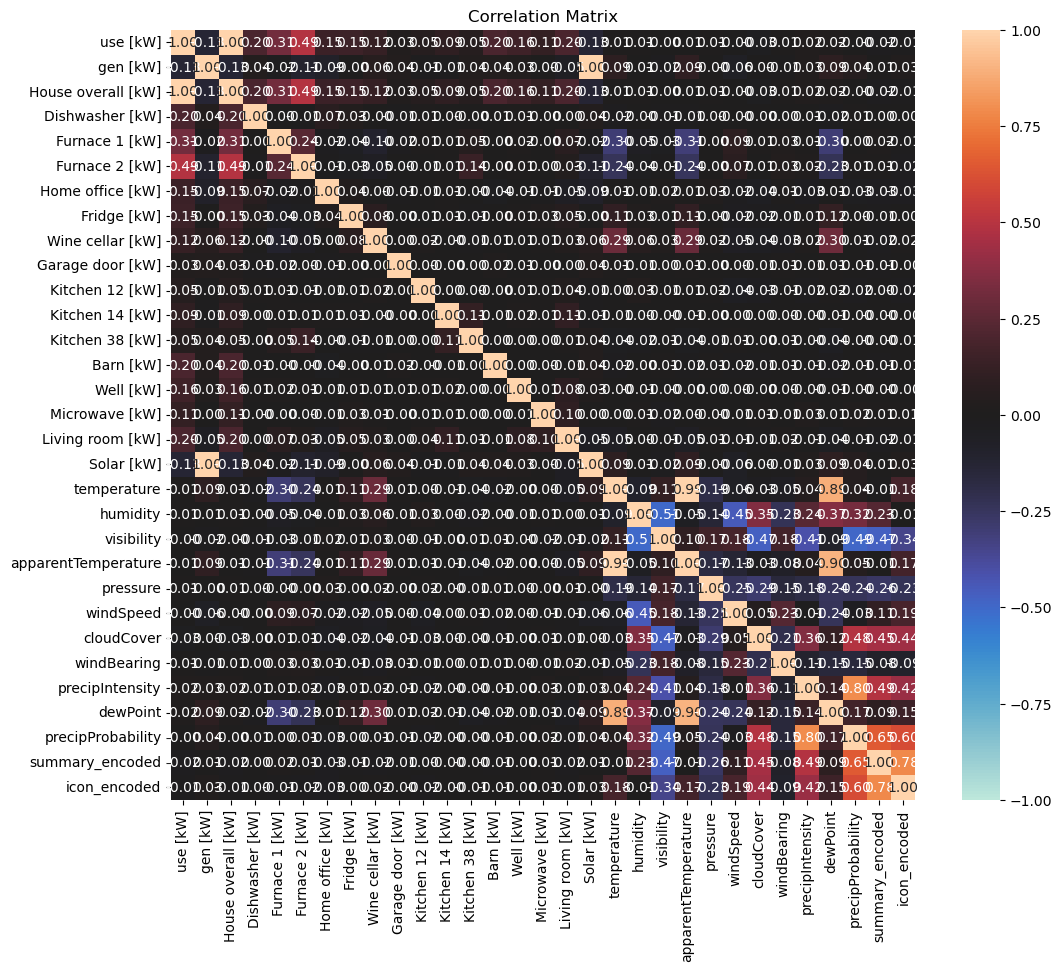

In [11]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('Correlation Matrix')
plt.show()

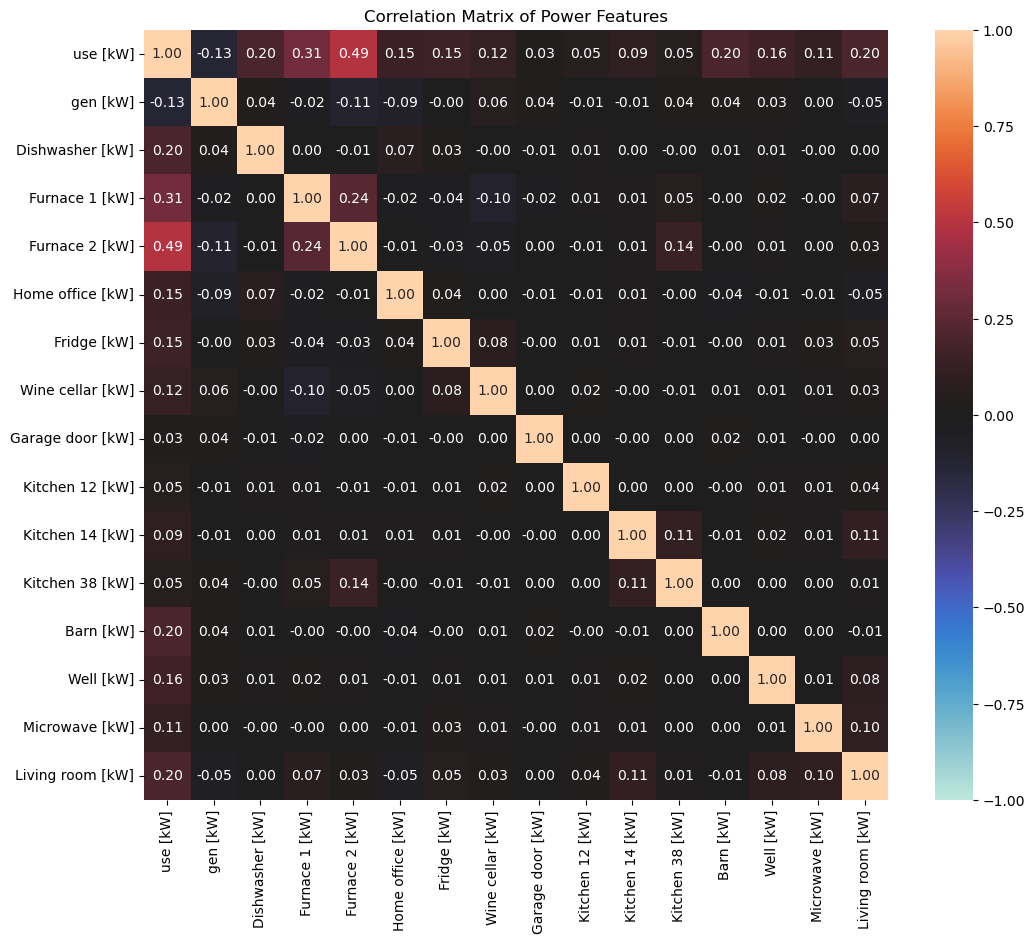

In [12]:
# Show correlation of just the power features
plt.figure(figsize=(12,10))
sns.heatmap(df[power_array].corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('Correlation Matrix of Power Features')
plt.show()

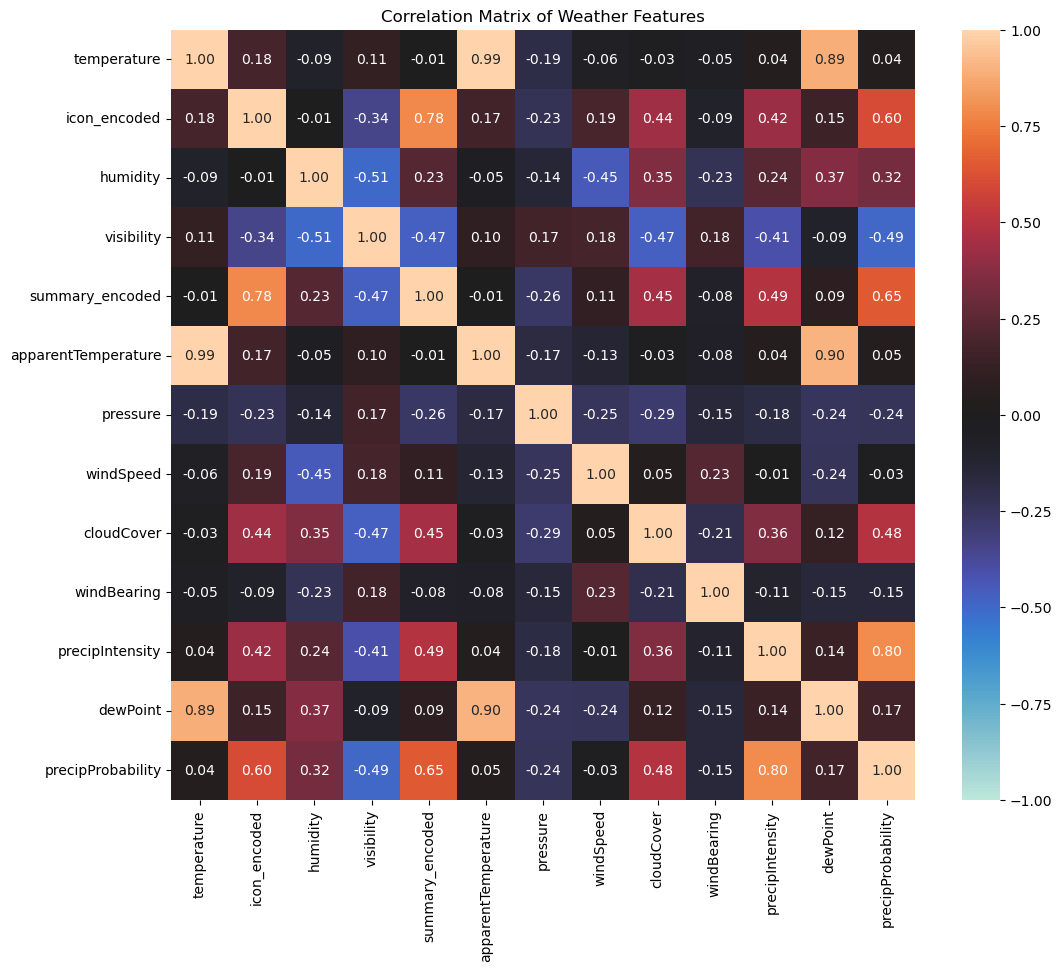

In [13]:
# Show correlation of just weather features
plt.figure(figsize=(12,10))
sns.heatmap(df[weather_array].corr(), annot=True, fmt='.2f', vmin=-1.0, vmax=1.0, center=0)
plt.title('Correlation Matrix of Weather Features')
plt.show()

## Check to see if use/House overall and gen/solar are identical

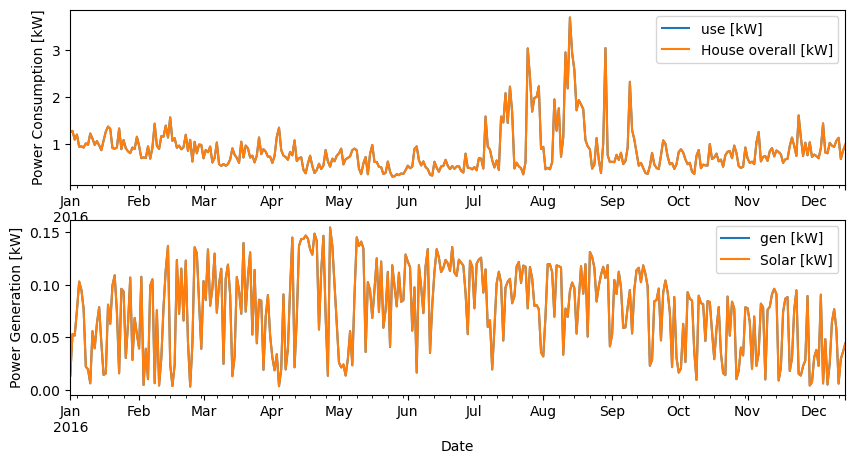

In [14]:
#They are indeed the same df (overlaping perfectly)
fig, axes = plt.subplots(2,1, figsize=(10,5))
df[['use [kW]','House overall [kW]']].resample('D').mean().plot(ax=axes[0])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Power Consumption [kW]')
df[['gen [kW]','Solar [kW]']].resample('D').mean().plot(ax=axes[1])
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Power Generation [kW]')

# drop duplicate columns
df = df.drop(columns='House overall [kW]')
df = df.drop(columns='Solar [kW]')

## Visualize the weather correlations

Text(0, 0.5, 'Humidity')

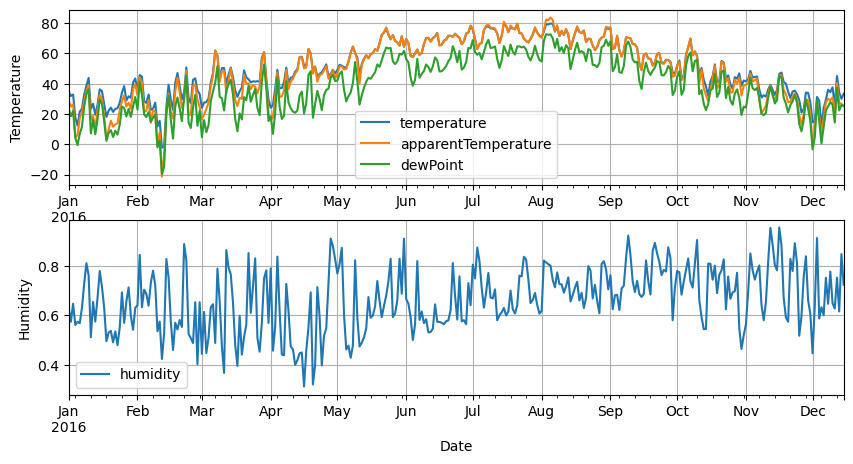

In [16]:
fig, axes = plt.subplots(2,1, figsize=(10,5))
df[['temperature','apparentTemperature', 'dewPoint']].resample('D').mean().plot(ax=axes[0], grid=True)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature')
df[['humidity']].resample('D').mean().plot(ax=axes[1], grid=True)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Humidity')

## Visualizations

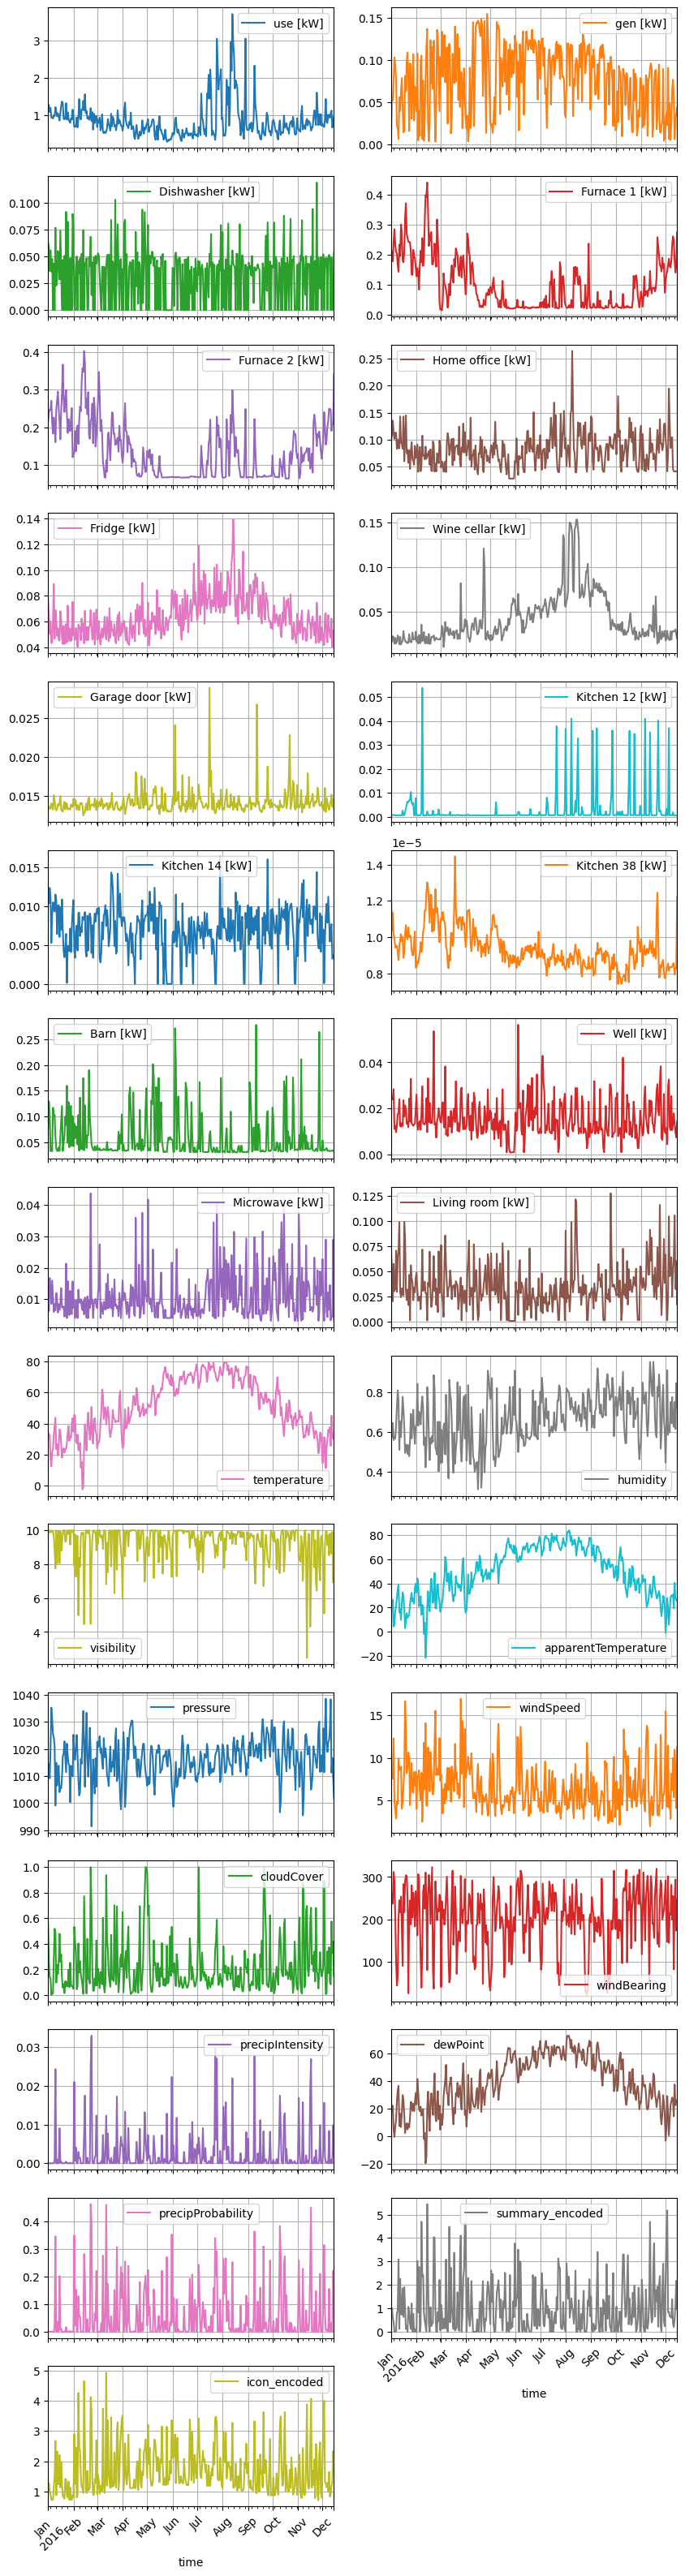

In [16]:
df.resample("D").mean().plot(subplots=True, layout=(-1, 2), figsize=(10, 40), grid=True, rot=45);

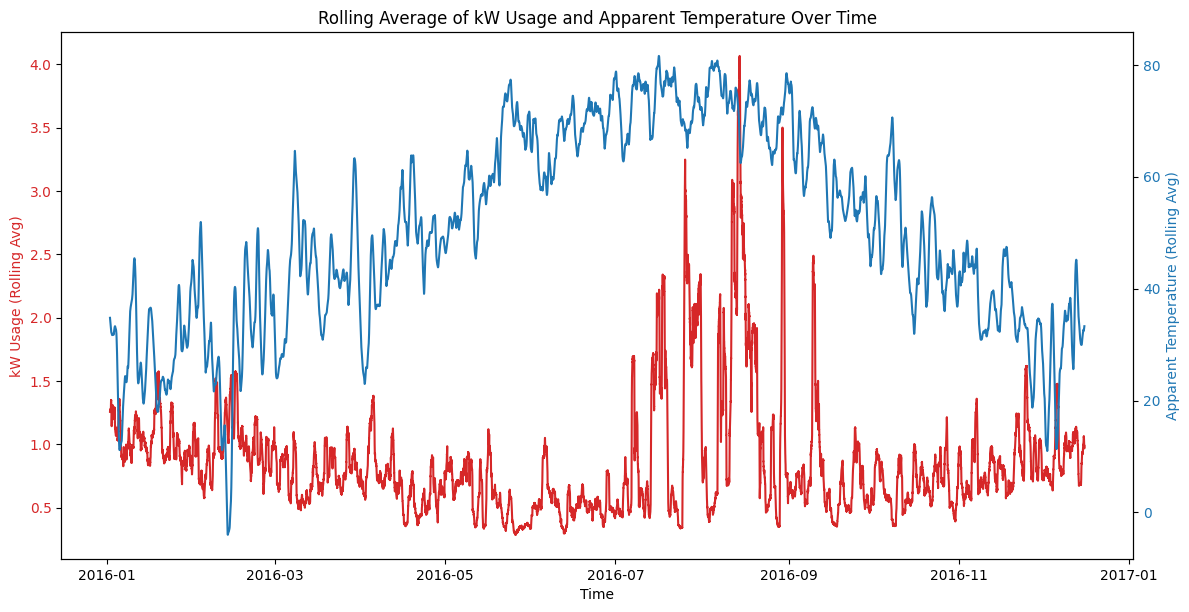

In [17]:
window_size = 60*24

# Calculate rolling averages
df['use [kW]_rolling_avg'] = df['use [kW]'].rolling(window=window_size).mean()
df['temperature_rolling_avg'] = df['temperature'].rolling(window=window_size).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('kW Usage (Rolling Avg)', color=color)
ax1.plot(df.index, df['use [kW]_rolling_avg'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Apparent Temperature (Rolling Avg)', color=color)  
ax2.plot(df.index, df['temperature_rolling_avg'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Rolling Average of kW Usage and Apparent Temperature Over Time')
plt.show()

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

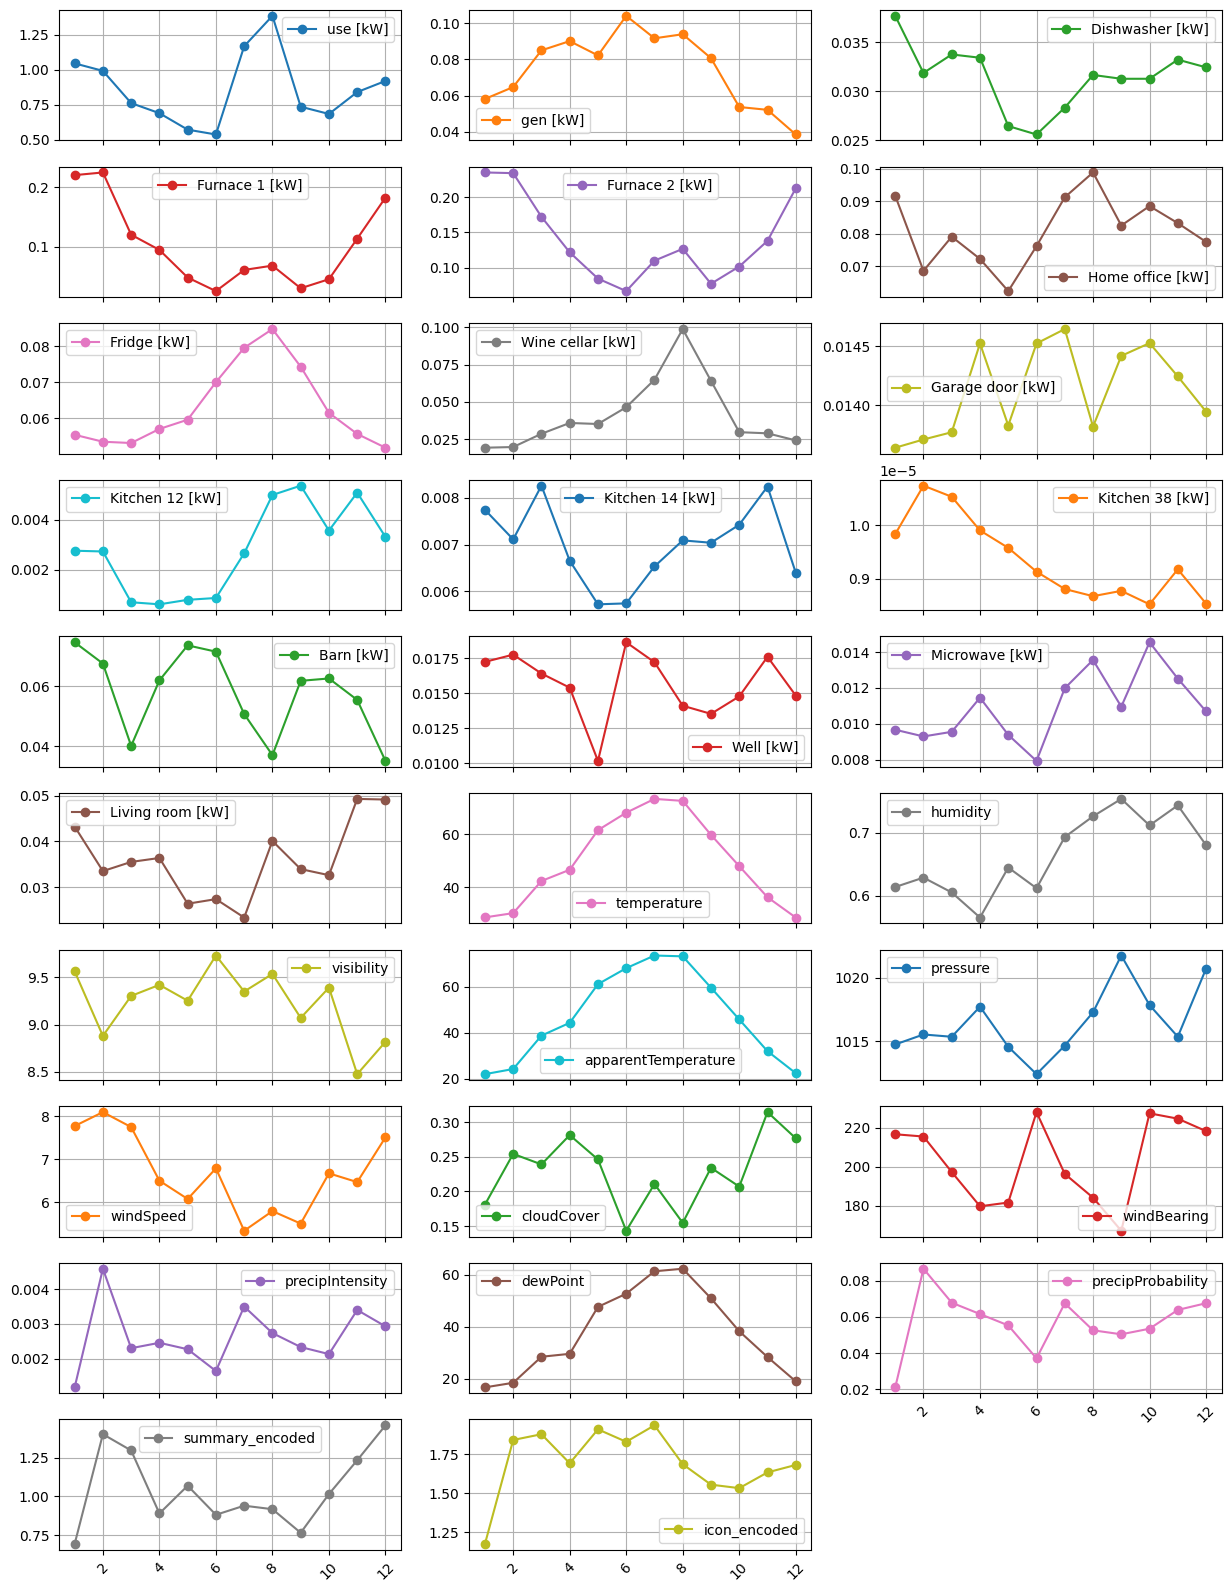

In [18]:
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.day_name()
df['hour'] = df.index.hour
df['minute'] = df.index.minute

##Averge consuption per month
mean_month = df.groupby('month').agg({col: 'mean' for col in df.columns if col in all_columns})
num_columns = len(mean_month.columns)
num_rows = -1
columns_per_row = 3
mean_month.plot(subplots=True, layout=(num_rows, columns_per_row), figsize=(15, 20),
                grid=True, rot=45, xlabel='', marker='o')

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

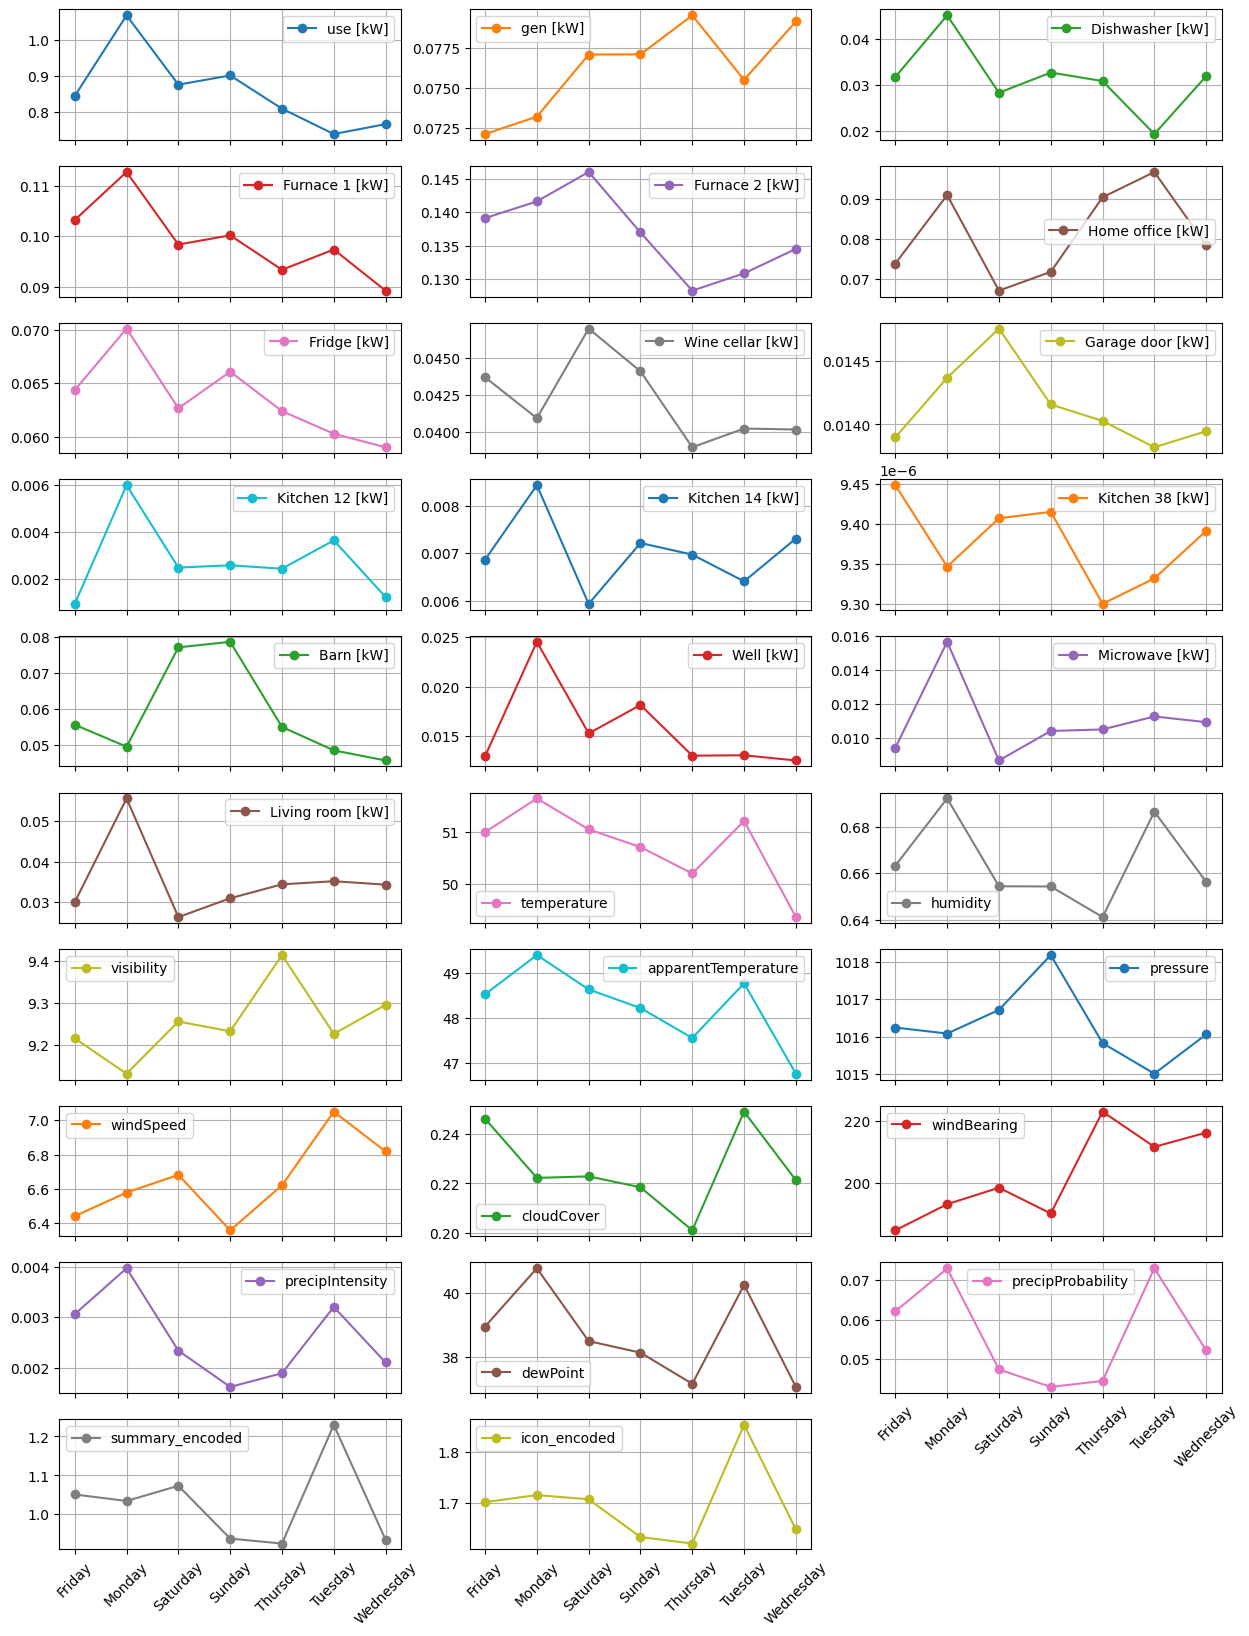

In [19]:
#Averge consuption per day of the week
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mean_weekday = df.groupby('weekday').agg({col: 'mean' for col in df.columns if col in all_columns})
num_columns = len(mean_weekday.columns)
num_rows = -1
columns_per_row = 3
mean_weekday.plot(subplots=True, layout=(num_rows, columns_per_row), figsize=(15, 20),
                grid=True, rot=45, xlabel='', marker='o')

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

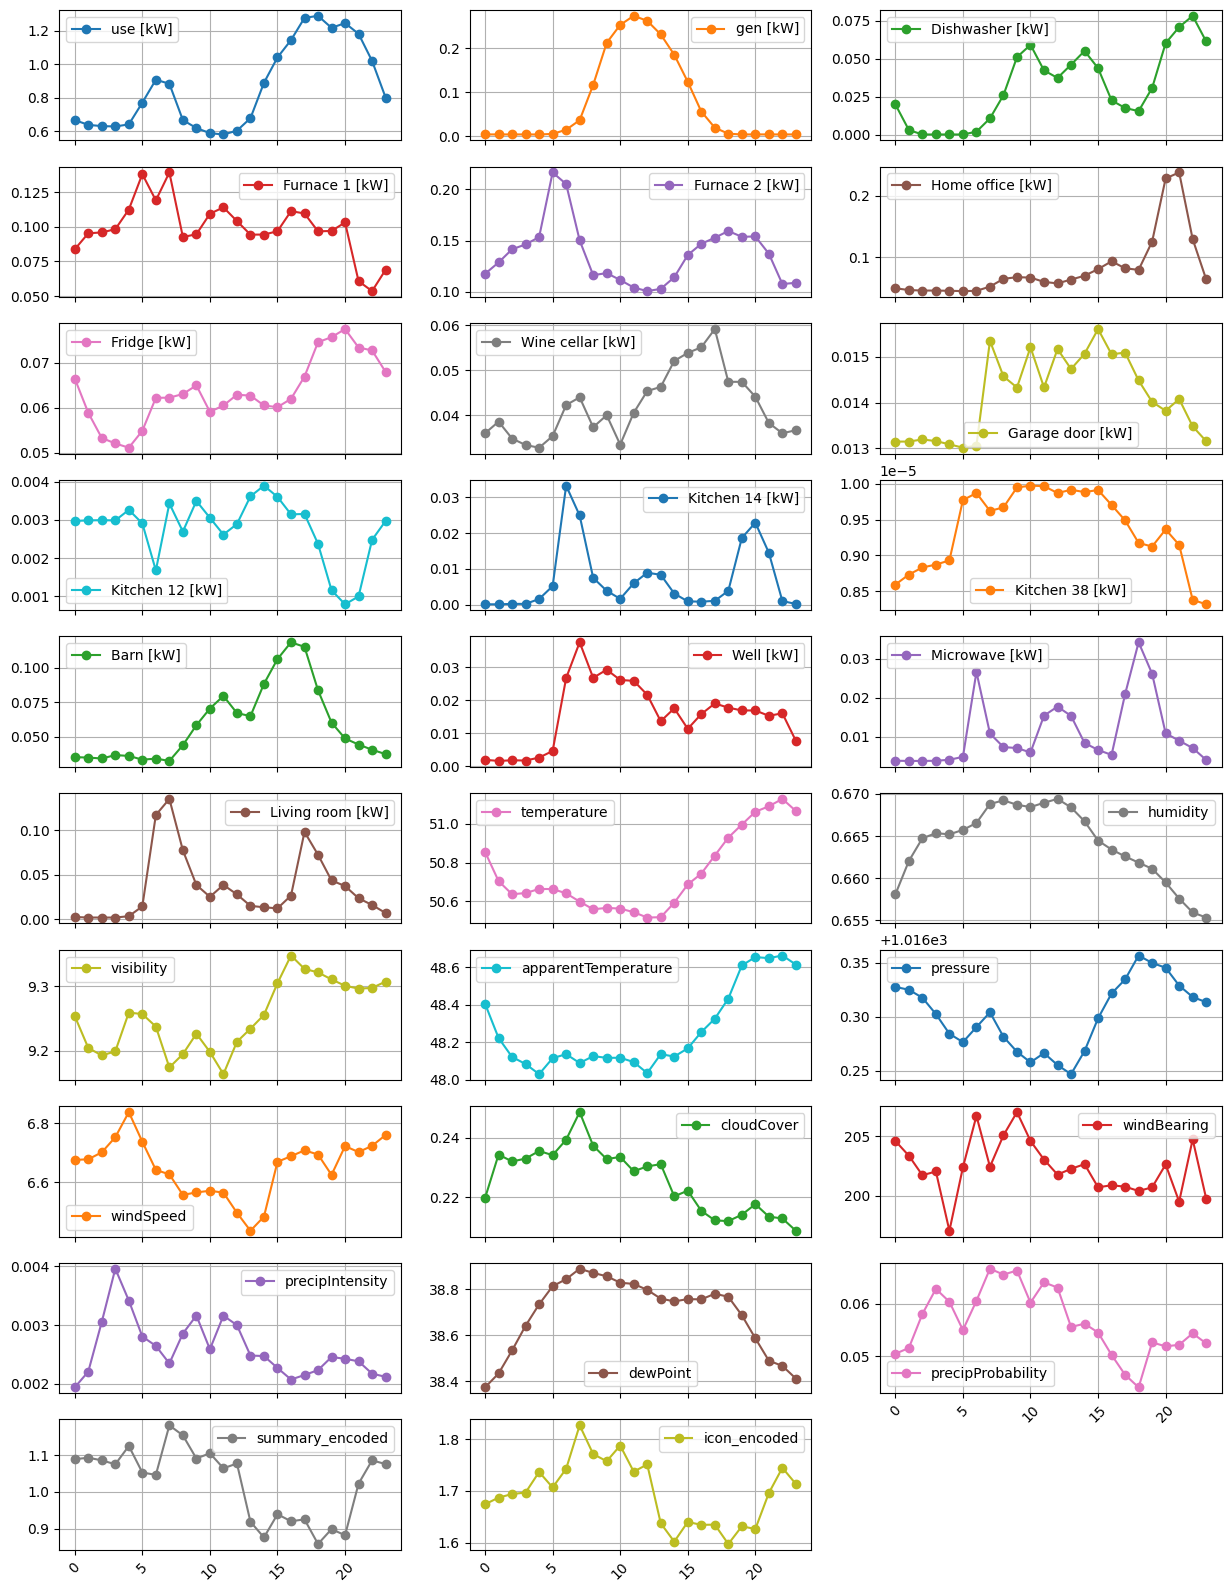

In [20]:
#Averge consuption per hour
mean_hour = df.groupby('hour').agg({col: 'mean' for col in df.columns if col in all_columns})
num_columns = len(mean_hour.columns)
num_rows = -1
columns_per_row = 3
mean_hour.plot(subplots=True, layout=(num_rows, columns_per_row), figsize=(15, 20),
                grid=True, rot=45, xlabel='', marker='o')

# Model Training

In [21]:
### Constants
MINUTES_AHEAD_TO_PREDICT = 10

In [22]:
## Drop the columns created for EDA usage
df = df.drop(columns=['use [kW]_rolling_avg', 'temperature_rolling_avg', 'month', 'day', 'weekday', 'hour', 'minute'])

In [23]:
df['hour_of_day'] = df.index.hour

In [24]:
# Filter the df down to just the first week from every month
# df = df[df.index.day <= 7]

# Filter to just january
# df = df[df.index.month == 1]

### LSTM Model for Predicting Energy Consumption ('use [kW]')


In [25]:
df.head()

use [kW]  gen [kW]  Dishwasher [kW]  Furnace 1 [kW]  \
time                                                                       
2016-01-01 00:00:00  0.932833  0.003483         0.000033        0.020700   
2016-01-01 00:01:00  0.934333  0.003467         0.000000        0.020717   
2016-01-01 00:02:00  0.931817  0.003467         0.000017        0.020700   
2016-01-01 00:03:00  1.022050  0.003483         0.000017        0.106900   
2016-01-01 00:04:00  1.139400  0.003467         0.000133        0.236933   

                     Furnace 2 [kW]  Home office [kW]  Fridge [kW]  \
time                                                                 
2016-01-01 00:00:00        0.061917          0.442633     0.124150   
2016-01-01 00:01:00        0.063817          0.444067     0.124000   
2016-01-01 00:02:00        0.062317          0.446067     0.123533   
2016-01-01 00:03:00        0.068517          0.446583     0.123133   
2016-01-01 00:04:00        0.063983          0.446533     0.122850   

                     Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  ...  \
time                                                                      ...   
2016-01-01 00:00:00          0.006983          0.013083         0.000417  ...   
2016-01-01 00:01:00          0.006983          0.013117         0.000417  ...   
2016-01-01 00:02:00          0.006983          0.013083         0.000433  ...   
2016-01-01 00:03:00          0.006983          0.013000         0.000433  ...   
2016-01-01 00:04:00          0.006850          0.012783         0.000450  ...   

                     pressure  windSpeed  cloudCover  windBearing  \
time                                                                
2016-01-01 00:00:00   1016.91       9.18    0.225885        282.0   
2016-01-01 00:01:00   1016.91       9.18    0.225885        282.0   
2016-01-01 00:02:00   1016.91       9.18    0.225885        282.0   
2016-01-01 00:03:00   1016.91       9.18    0.225885        282.0   
2016-01-01 00:04:00   1016.91       9.18    0.225885        282.0   

                     precipIntensity  dewPoint  precipProbability  \
time                                                                
2016-01-01 00:00:00              0.0      24.4                0.0   
2016-01-01 00:01:00              0.0      24.4                0.0   
2016-01-01 00:02:00              0.0      24.4                0.0   
2016-01-01 00:03:00              0.0      24.4                0.0   
2016-01-01 00:04:00              0.0      24.4                0.0   

                     summary_encoded  icon_encoded  hour_of_day  
time                                                             
2016-01-01 00:00:00                0             0            0  
2016-01-01 00:01:00                0             0            0  
2016-01-01 00:02:00                0             0            0  
2016-01-01 00:03:00                0             0            0  
2016-01-01 00:04:00                0             0            0  

[5 rows x 30 columns]

In [26]:
# check df for null values
df.isnull().sum()

use [kW]               0
gen [kW]               0
Dishwasher [kW]        0
Furnace 1 [kW]         0
Furnace 2 [kW]         0
Home office [kW]       0
Fridge [kW]            0
Wine cellar [kW]       0
Garage door [kW]       0
Kitchen 12 [kW]        0
Kitchen 14 [kW]        0
Kitchen 38 [kW]        0
Barn [kW]              0
Well [kW]              0
Microwave [kW]         0
Living room [kW]       0
temperature            0
humidity               0
visibility             0
apparentTemperature    0
pressure               0
windSpeed              0
cloudCover             0
windBearing            0
precipIntensity        0
dewPoint               0
precipProbability      0
summary_encoded        0
icon_encoded           0
hour_of_day            0
dtype: int64

In [27]:
correlation_matrix = df.corr()
target_correlation = correlation_matrix['use [kW]']

# Filter based on the threshold
# We use .abs() to handle both positive and negative correlations
filtered_features = target_correlation[(target_correlation >= 0.3) | (target_correlation <= -0.3)]

# If you want to exclude the target variable itself from the list, assuming it's included
# filtered_features = filtered_features.drop('use [kW]', errors='ignore')

# Get the list of feature names
feature_list = filtered_features.index.tolist()
feature_list

['use [kW]', 'Furnace 1 [kW]', 'Furnace 2 [kW]']

In [28]:
feature_columns = feature_list

# Select features and target
features = df[feature_columns]
target = df['use [kW]']

# Scale features
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [29]:
def create_sequences(input_data, output_data, sequence_length, time_ahead):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - time_ahead):
        X.append(input_data[i:(i + sequence_length)])
        y.append(output_data[i + sequence_length + time_ahead])
    return np.array(X), np.array(y)

sequence_length = 10  # 10 minutes
time_ahead = MINUTES_AHEAD_TO_PREDICT  # Predict the next minute
X, y = create_sequences(scaled_features, scaled_target, sequence_length, time_ahead)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
split_index = int(len(X) * 0.8)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# print the shape of the training and testing data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(403112, 10, 3) (100778, 10, 3) (403112, 1) (100778, 1)


In [30]:
# Example check for NaNs or infinite values in your dataset
print(np.any(np.isnan(X)), np.any(np.isnan(y)))  # Check for NaN values
print(np.any(np.isinf(X)), np.any(np.isinf(y)))  # Check for infinite values

False False
False False


## LSTM

In [31]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, X.shape[2])))
# lstm_model.add(Dense(1))
lstm_model.add(Dense(1, kernel_initializer='glorot_uniform'))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.2,          # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,
    min_delta=0.001,     # Threshold for measuring the new optimum, to only focus on significant changes
    cooldown=0,          # Number of epochs to wait before resuming normal operation after lr has been reduced
    min_lr=0.0001        # Lower bound on the learning rate
)


history = lstm_model.fit(
    X, y,
    epochs=100,  # Set a higher number of epochs; EarlyStopping will halt training when necessary
    batch_size=32,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stopping, reduce_lr]  # Include the callbacks here
)

# save the model
lstm_model.save('./model.h5')


Epoch 1/100
14172/14172 - 251s - loss: 0.0032 - val_loss: 0.0012 - lr: 0.0010 - 251s/epoch - 18ms/step
Epoch 2/100
14172/14172 - 257s - loss: 0.0031 - val_loss: 0.0012 - lr: 0.0010 - 257s/epoch - 18ms/step
Epoch 3/100
14172/14172 - 258s - loss: 0.0030 - val_loss: 0.0013 - lr: 0.0010 - 258s/epoch - 18ms/step
Epoch 4/100
14172/14172 - 255s - loss: 0.0030 - val_loss: 0.0012 - lr: 0.0010 - 255s/epoch - 18ms/step
Epoch 5/100
14172/14172 - 249s - loss: 0.0030 - val_loss: 0.0012 - lr: 0.0010 - 249s/epoch - 18ms/step
Epoch 6/100

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
14172/14172 - 256s - loss: 0.0029 - val_loss: 0.0012 - lr: 0.0010 - 256s/epoch - 18ms/step
Epoch 7/100
14172/14172 - 252s - loss: 0.0029 - val_loss: 0.0012 - lr: 2.0000e-04 - 252s/epoch - 18ms/step
Epoch 8/100
14172/14172 - 251s - loss: 0.0028 - val_loss: 0.0012 - lr: 2.0000e-04 - 251s/epoch - 18ms/step
Epoch 9/100
14172/14172 - 252s - loss: 0.0028 - val_loss: 0.0012 - lr: 2.0000e-04 - 252s/e

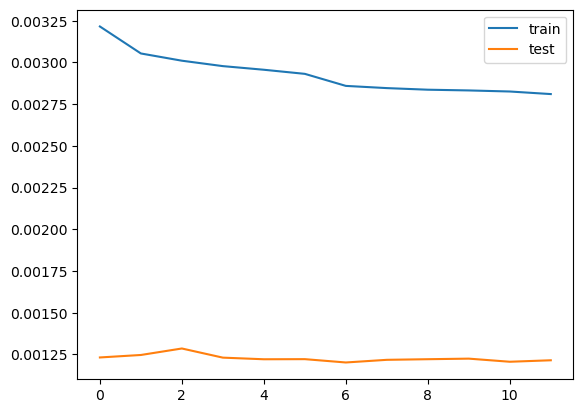

In [32]:
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [33]:
test_predictions = lstm_model.predict(X_test)
test_predictions_rescaled = scaler_target.inverse_transform(test_predictions)
test_y_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))

mse = mean_squared_error(test_y_rescaled, test_predictions_rescaled)
rmse = sqrt(mse)
mae = mean_absolute_error(test_y_rescaled, test_predictions_rescaled)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


3150/3150 [==============================] - 17s 5ms/step
MSE: 0.2506907470532965
RMSE: 0.5006902705798232
MAE: 0.31568480847868097


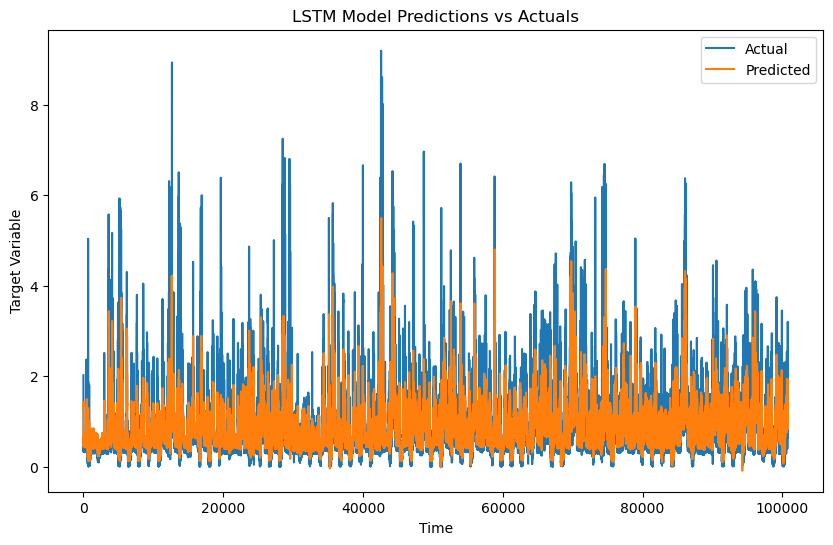

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(test_y_rescaled, label='Actual')
plt.plot(test_predictions_rescaled, label='Predicted')
plt.title('LSTM Model Predictions vs Actuals')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

### Linear Regression Model for Forecasting Temperature

In [35]:
# Calculate the correlation matrix
corr_matrix = df[weather_array].corr()

# Focus on correlations with temperature
temp_corr = corr_matrix['temperature']

# Filter features based on correlation threshold
highly_correlated_features = temp_corr[(temp_corr.abs() >= 0.3) & (temp_corr.index != 'temperature') & (temp_corr.index != 'apparentTemperature')].index.tolist()

print("Features highly correlated with temperature:", highly_correlated_features)


Features highly correlated with temperature: ['dewPoint']


In [36]:
# include temperature in the list of features since we are attempting to predict future temperature
highly_correlated_features.append('temperature')

df['temperature_next'] = df['temperature'].shift(-MINUTES_AHEAD_TO_PREDICT)
df = df[:-MINUTES_AHEAD_TO_PREDICT]  # Remove the last row as it now has NaN for 'temperature_next'

X = df[highly_correlated_features]
y = df['temperature_next']

# Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# split based on the first 80% of the data

split_index = int(len(X) * 0.8)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]


In [37]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

predictions = lr_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")

# store model
joblib.dump(lr_model, 'temperature_model.pkl')

Test MSE: 0.5496897499889629
Test RMSE: 0.7414106486886757


['temperature_model.pkl']

In [38]:
feature_importance = pd.Series(lr_model.coef_, index=highly_correlated_features)
print("Feature Importance:\n", feature_importance)


Feature Importance:
 dewPoint       0.004216
temperature    0.995174
dtype: float64


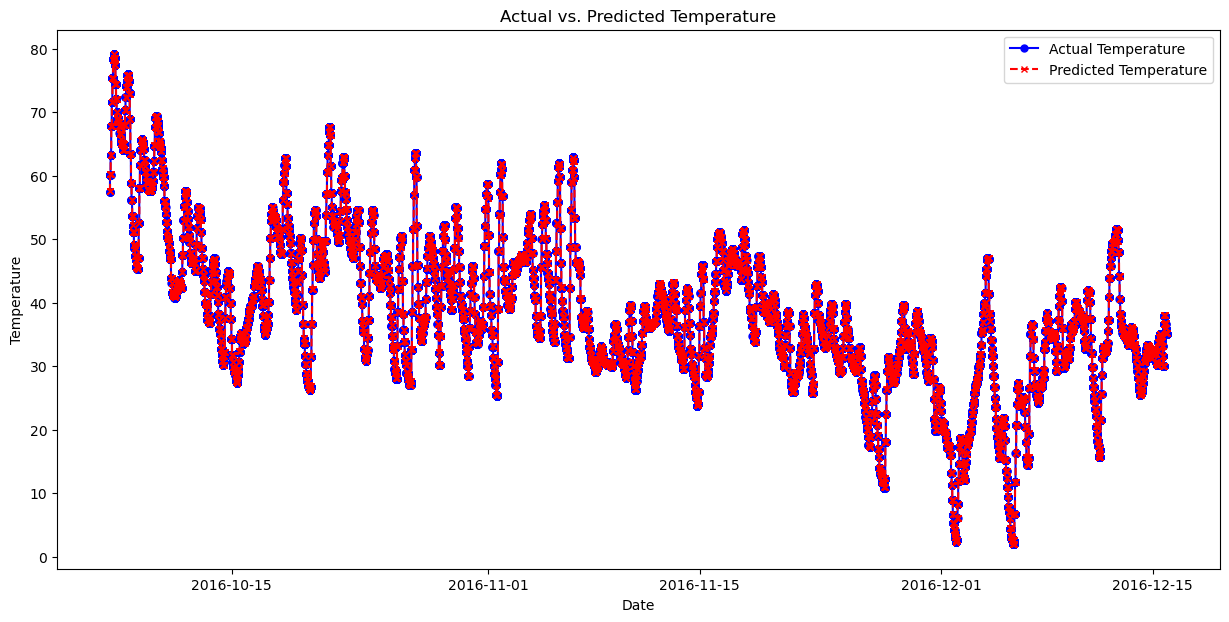

In [39]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}, index=y_test.index)

plt.figure(figsize=(15, 7))
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual Temperature', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted Temperature', color='red', marker='x', linestyle='--', markersize=5)

plt.title('Actual vs. Predicted Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()

plt.show()

# Dataset creation for Dashboard

In [40]:
# Rename temperature_next to temperature_next_MINUTES_AHEAD_TO_PREDICT_minutes
df.rename(columns={'temperature_next': f'temperature_next_{MINUTES_AHEAD_TO_PREDICT}_minutes'}, inplace=True)

# create a column for the predicted use [kW] from the LSTM model
df[f'use_[kW]_next_{MINUTES_AHEAD_TO_PREDICT}_minutes'] = df['use [kW]'].shift(-MINUTES_AHEAD_TO_PREDICT)

In [41]:
# filter df to only the test data
df = df[split_index:]

In [42]:
# find the smallest length of df, test_predictions_rescaled, and predictions
min_length = min(len(df), len(test_predictions_rescaled), len(predictions))
print(f"Smallest length: {min_length}")
# trim all down to smallest length
df = df[:min_length]
test_predictions_rescaled = test_predictions_rescaled[:min_length]
predictions = predictions[:min_length]

Smallest length: 100778


In [43]:
# add the lstm predictions to the df
# drop the last row of the test_predictions_rescaled
df[f'lstm_prediction_use_kw_next_{MINUTES_AHEAD_TO_PREDICT}_minutes'] = test_predictions_rescaled

# add the linear regression predictions to the df
df[f'linear_regression_prediction_temperature_next_{MINUTES_AHEAD_TO_PREDICT}_minutes'] = predictions

In [44]:
# write out df to a csv
df.to_csv('./predictions.csv')

In [45]:
df.head()

use [kW]  gen [kW]  Dishwasher [kW]  Furnace 1 [kW]  \
time                                                                       
2016-10-06 22:40:00  0.887600  0.004933         0.046300        0.020433   
2016-10-06 22:41:00  1.914867  0.004917         1.019900        0.018583   
2016-10-06 22:42:00  2.283350  0.004900         1.355867        0.017933   
2016-10-06 22:43:00  2.265800  0.004900         1.352700        0.017883   
2016-10-06 22:44:00  2.218167  0.004817         1.343200        0.017750   

                     Furnace 2 [kW]  Home office [kW]  Fridge [kW]  \
time                                                                 
2016-10-06 22:40:00        0.063267          0.070900     0.005083   
2016-10-06 22:41:00        0.069350          0.065533     0.004400   
2016-10-06 22:42:00        0.070567          0.063767     0.004183   
2016-10-06 22:43:00        0.070267          0.063933     0.004183   
2016-10-06 22:44:00        0.070283          0.063500     0.004200   

                     Wine cellar [kW]  Garage door [kW]  Kitchen 12 [kW]  ...  \
time                                                                      ...   
2016-10-06 22:40:00          0.129250          0.012917         0.000833  ...   
2016-10-06 22:41:00          0.127983          0.011833         0.000950  ...   
2016-10-06 22:42:00          0.127517          0.011467         0.001017  ...   
2016-10-06 22:43:00          0.127267          0.011450         0.001067  ...   
2016-10-06 22:44:00          0.127217          0.011367         0.001050  ...   

                     precipIntensity  dewPoint  precipProbability  \
time                                                                
2016-10-06 22:40:00              0.0     56.53                0.0   
2016-10-06 22:41:00              0.0     56.53                0.0   
2016-10-06 22:42:00              0.0     56.53                0.0   
2016-10-06 22:43:00              0.0     56.53                0.0   
2016-10-06 22:44:00              0.0     56.53                0.0   

                     summary_encoded  icon_encoded  hour_of_day  \
time                                                              
2016-10-06 22:40:00                0             2           22   
2016-10-06 22:41:00                0             2           22   
2016-10-06 22:42:00                0             2           22   
2016-10-06 22:43:00                0             2           22   
2016-10-06 22:44:00                0             2           22   

                     temperature_next_10_minutes  use_[kW]_next_10_minutes  \
time                                                                         
2016-10-06 22:40:00                        57.49                  2.131200   
2016-10-06 22:41:00                        57.49                  2.129683   
2016-10-06 22:42:00                        57.49                  2.019767   
2016-10-06 22:43:00                        57.49                  1.839867   
2016-10-06 22:44:00                        57.49                  1.848200   

                     lstm_prediction_use_kw_next_10_minutes  \
time                                                          
2016-10-06 22:40:00                                1.340331   
2016-10-06 22:41:00                                1.411025   
2016-10-06 22:42:00                                1.422542   
2016-10-06 22:43:00                                1.409162   
2016-10-06 22:44:00                                1.394071   

                     linear_regression_prediction_temperature_next_10_minutes  
time                                                                           
2016-10-06 22:40:00                                          57.538057         
2016-10-06 22:41:00                                          57.538057         
2016-10-06 22:42:00                                          57.538057         
2016-10-06 22:43:00                                          57.538057         
2016-1

In [46]:
df.columns

Index(['use [kW]', 'gen [kW]', 'Dishwasher [kW]', 'Furnace 1 [kW]',
       'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]', 'Wine cellar [kW]',
       'Garage door [kW]', 'Kitchen 12 [kW]', 'Kitchen 14 [kW]',
       'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]', 'Microwave [kW]',
       'Living room [kW]', 'temperature', 'humidity', 'visibility',
       'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability',
       'summary_encoded', 'icon_encoded', 'hour_of_day',
       'temperature_next_10_minutes', 'use_[kW]_next_10_minutes',
       'lstm_prediction_use_kw_next_10_minutes',
       'linear_regression_prediction_temperature_next_10_minutes'],
      dtype='object')

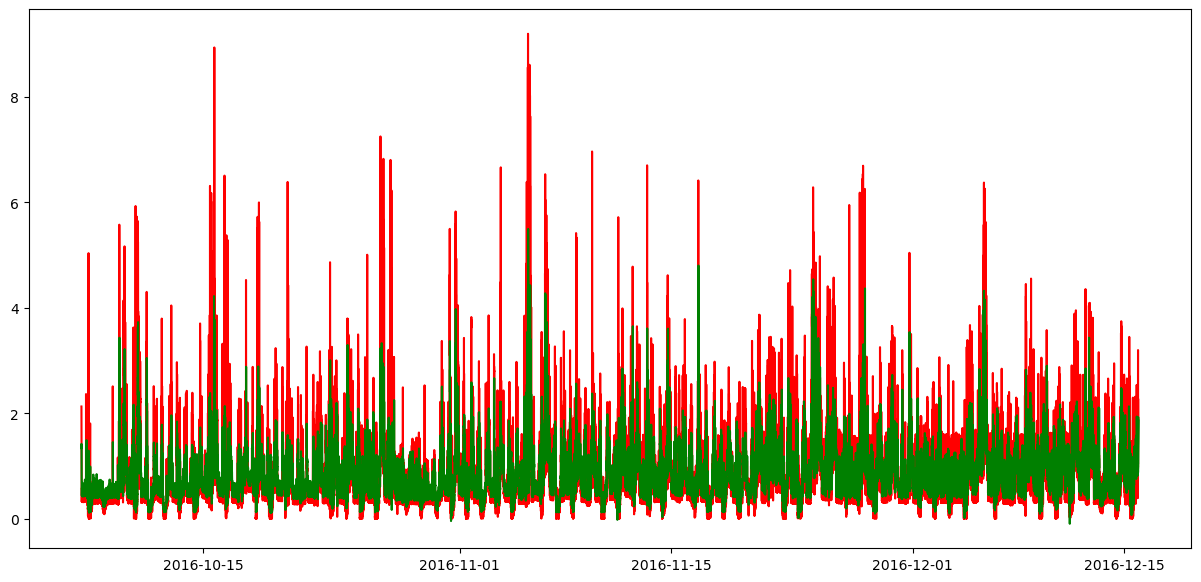

In [47]:
# plot use_[kW]_next_10_minutes and lstm_prediction_use_kw_next_10_minutes
plt.figure(figsize=(15, 7))
plt.plot(df.index, df[f'use_[kW]_next_{MINUTES_AHEAD_TO_PREDICT}_minutes'], label=f'Actual Use [kW]', color='red')
plt.plot(df.index, df[f'lstm_prediction_use_kw_next_{MINUTES_AHEAD_TO_PREDICT}_minutes'], label=f'Predicted Use [kW] (LSTM)', color='green')


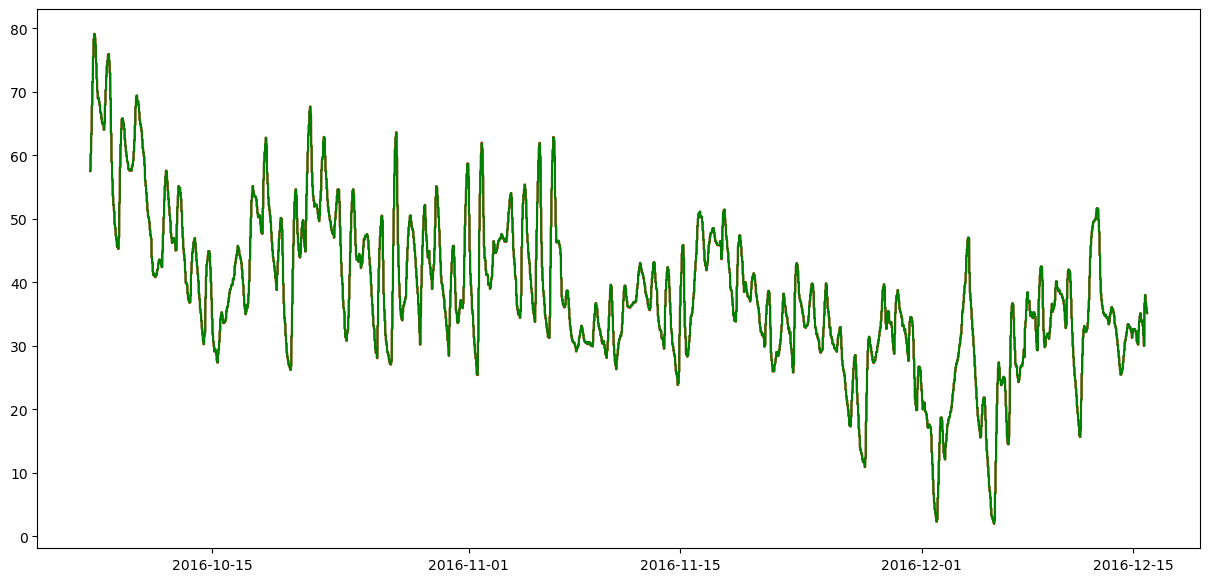

In [48]:
# plot temperature_next_10_minutes and linear_regression_prediction_temperature_next_10_minutes
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['temperature'], label=f'Actual Temperature', color='red')
plt.plot(df.index, df[f'linear_regression_prediction_temperature_next_{MINUTES_AHEAD_TO_PREDICT}_minutes'], label=f'Predicted Temperature (Linear Regression)', color='green')

In [49]:
# print df min date
print(df.index.min())
# print df max date
print(df.index.max())

2016-10-06 22:40:00
2016-12-15 22:17:00
